In [1]:
!pip install transformers


In [2]:
!pip install -q datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.1 MB/s eta 0:00:00


In [3]:
from datasets import load_dataset
dataset = load_dataset("ybelkada/football-dataset", split="train")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/6 [00:00<?, ? examples/s]

In [4]:
dataset[0]["text"]

"Benzema after Real Mardid's win against PSG"

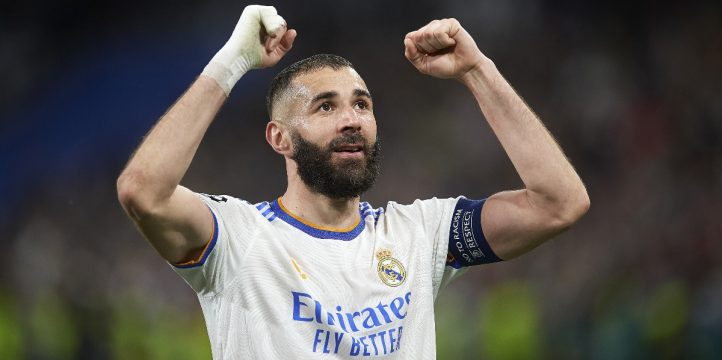

In [ ]:
dataset[0]["image"]

In [5]:
from torch.utils.data import Dataset, DataLoader

class ImageCaptioningDataset(Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        encoding = self.processor(images=item["image"], text=item["text"], padding="max_length", return_tensors="pt")
        # remove batch dimension
        encoding = {k:v.squeeze() for k,v in encoding.items()}
        return encoding

In [6]:
from transformers import AutoProcessor, BlipForConditionalGeneration

processor = AutoProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

In [7]:

#trainloader recursively load data , batch= 2( two images at a time)
train_dataset = ImageCaptioningDataset(dataset, processor)
train_dataloader = DataLoader(train_dataset,shuffle=True, batch_size=2)

In [8]:
 import torch

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

for epoch in range(50):
    print("Epoch:", epoch)
    for idx, batch in enumerate(train_dataloader):
        input_ids = batch.pop("input_ids").to(device)
        pixel_values = batch.pop("pixel_values").to(device)

        outputs = model(input_ids=input_ids,
                        pixel_values=pixel_values,
                        labels=input_ids)

        loss = outputs.loss

        print("Loss:", loss.item())

        loss.backward()

        optimizer.step()
        optimizer.zero_grad()


Epoch: 0


We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Loss: 12.976122856140137
Loss: 10.300811767578125
Loss: 10.22677230834961
Epoch: 1
Loss: 10.180924415588379
Loss: 10.20765209197998
Loss: 10.176177024841309
Epoch: 2
Loss: 10.142487525939941
Loss: 10.135102272033691
Loss: 10.158499717712402
Epoch: 3
Loss: 10.12005615234375
Loss: 10.118020057678223
Loss: 10.089301109313965
Epoch: 4
Loss: 10.059755325317383
Loss: 10.086812019348145
Loss: 10.078594207763672
Epoch: 5
Loss: 10.053525924682617
Loss: 10.054891586303711
Loss: 10.006142616271973
Epoch: 6
Loss: 10.001119613647461
Loss: 10.010775566101074
Loss: 9.906622886657715
Epoch: 7
Loss: 9.708874702453613
Loss: 9.459064483642578
Loss: 9.206965446472168
Epoch: 8
Loss: 8.916773796081543
Loss: 8.686720848083496
Loss: 8.445610046386719
Epoch: 9
Loss: 8.224720001220703
Loss: 8.06483268737793
Loss: 7.8232808113098145
Epoch: 10
Loss: 7.634763240814209
Loss: 7.488443851470947
Loss: 7.339666843414307
Epoch: 11
Loss: 7.186647415161133
Loss: 7.011072158813477
Loss: 6.855015277862549
Epoch: 12
Loss: 6.

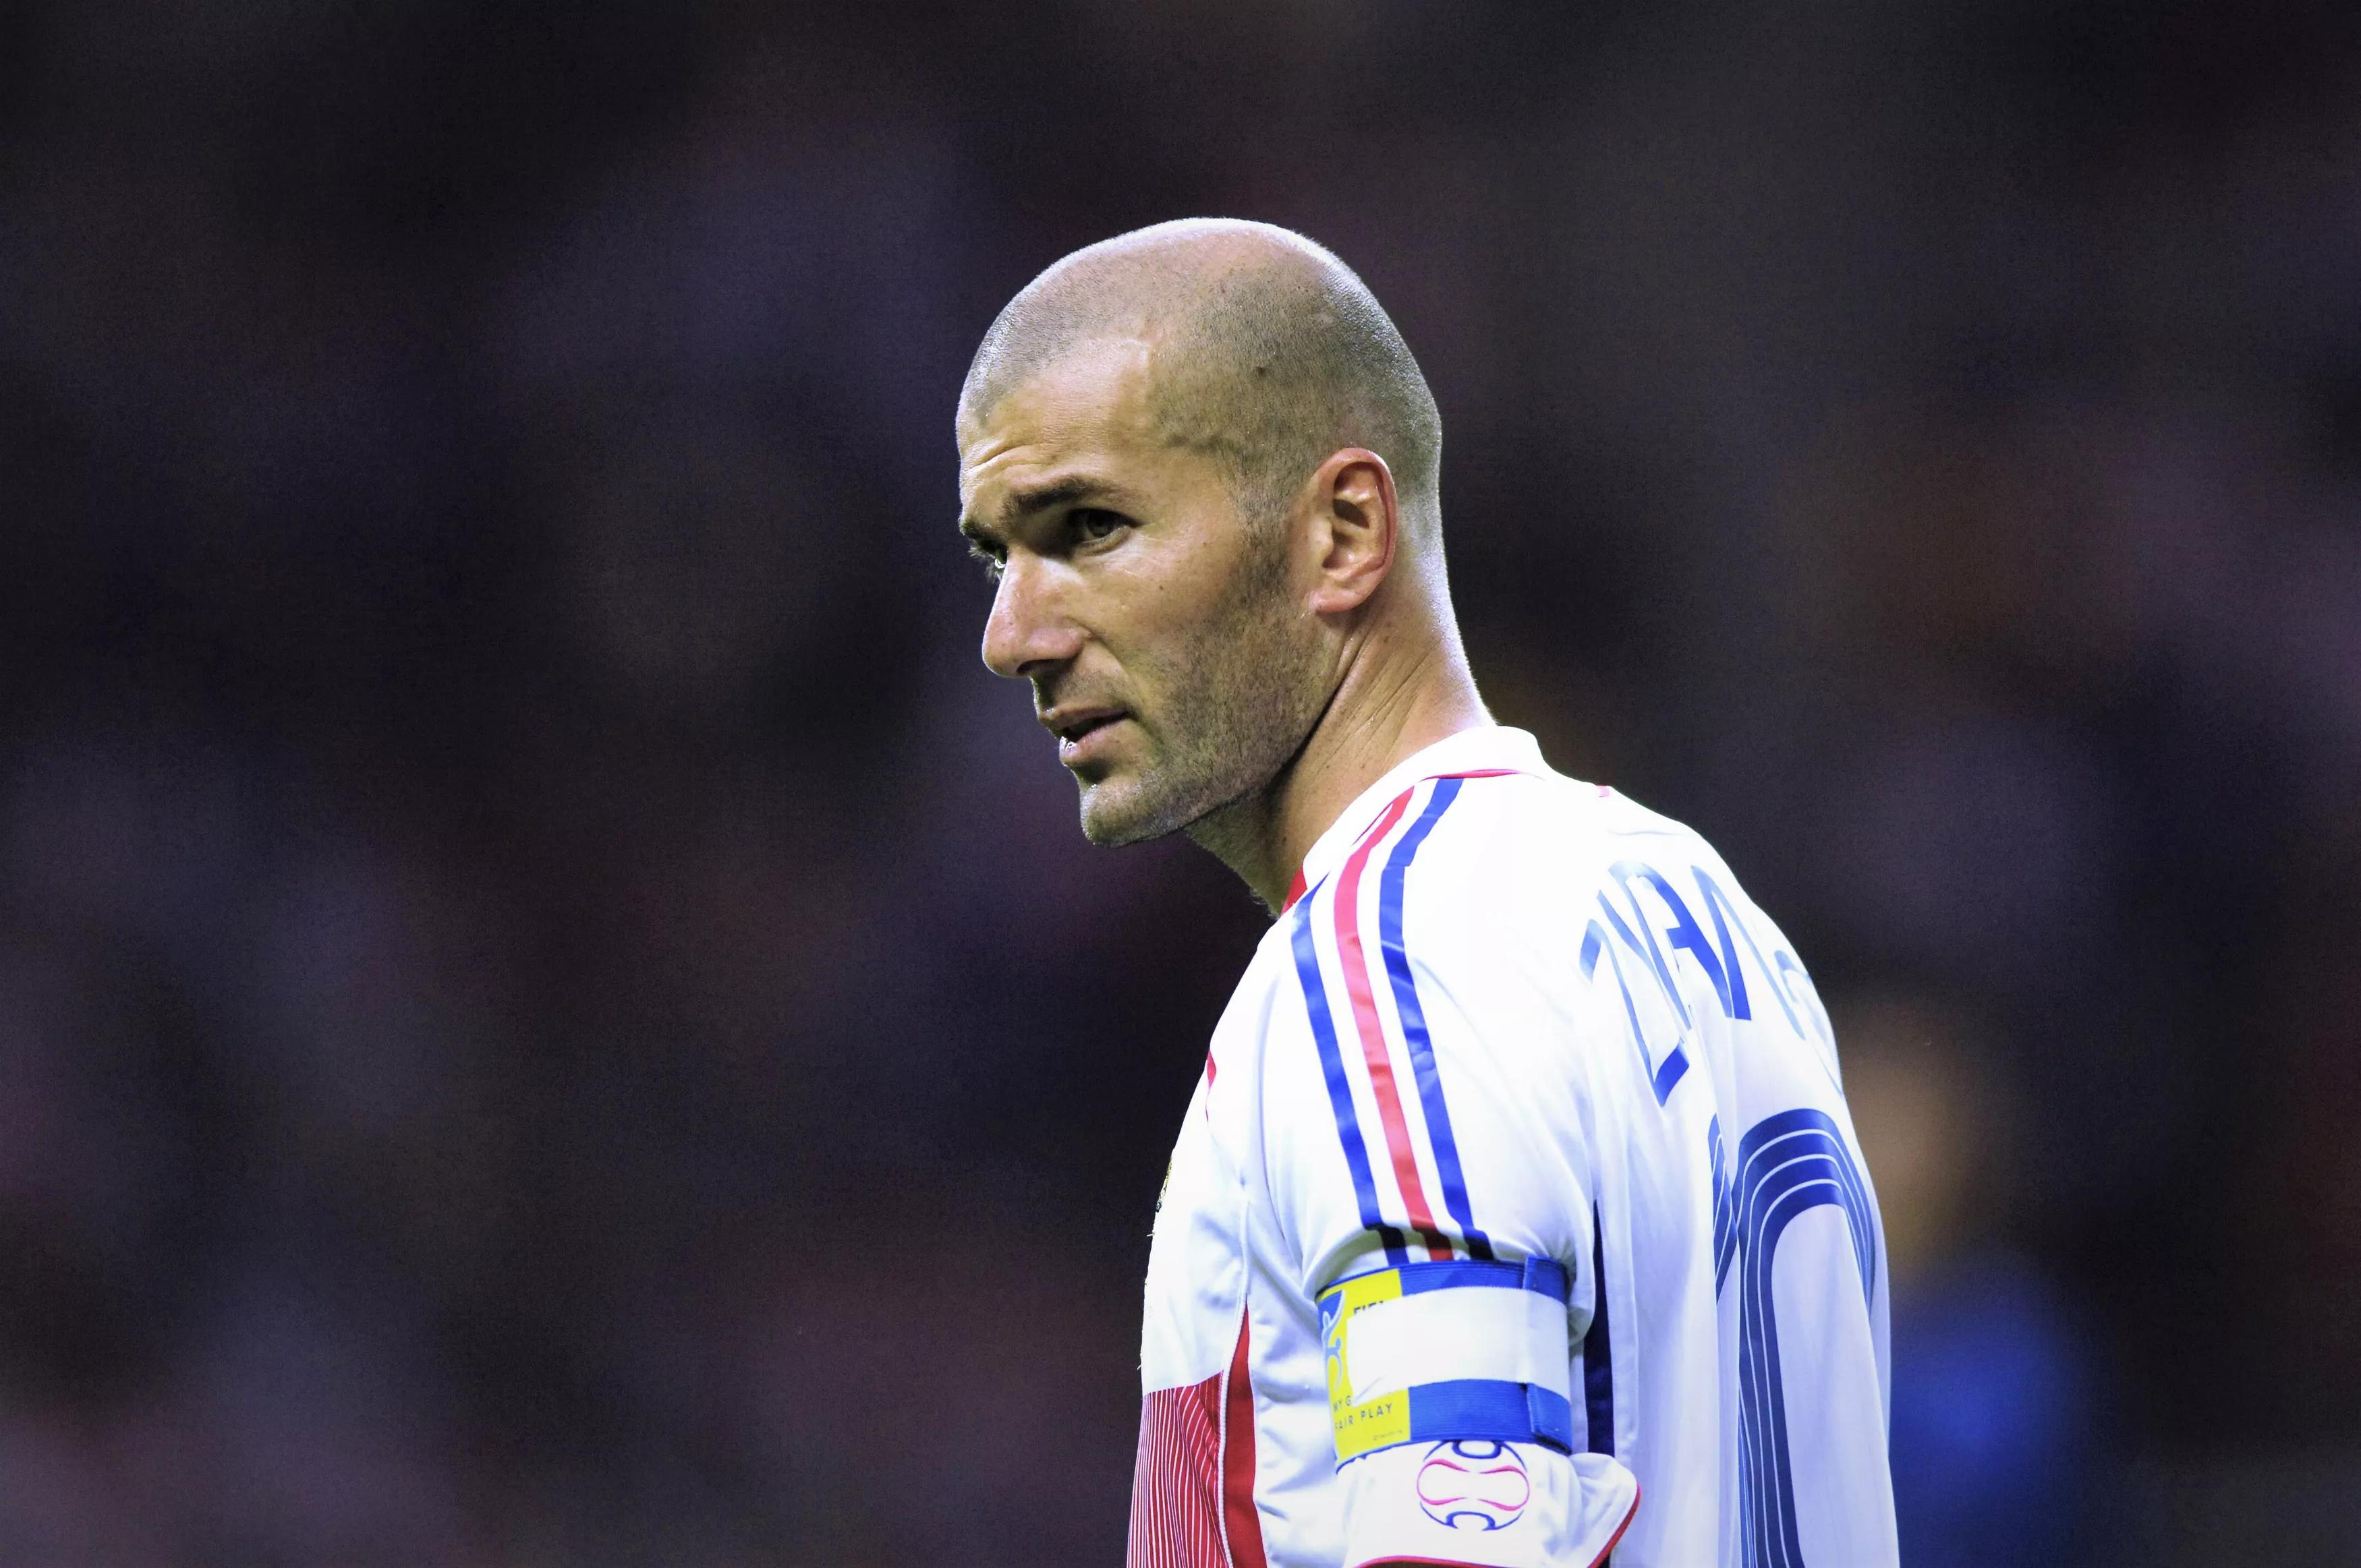

In [10]:
example = dataset[5]
image = example["image"]
image

In [13]:
inputs = processor(images= image, return_tensors="pt").to(device)
pixel_values = inputs.pixel_values

generated_ids = model.generate(pixel_values= pixel_values, max_length=50)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens= True)[0]
print(generated_caption)

zidane with france in 2006 world cup
